In [1]:
import warnings
from IPython.core.interactiveshell import InteractiveShell
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.tools.sm_exceptions import ConvergenceWarning
pd.options.display.max_rows = 5
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# 関数 (orderの最適化)
def selectparameter(DATA, s):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in itertools.product(p, d, q)]
    parameters = []
    BICs = np.array([])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)

        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    mod = sm.tsa.statespace.SARIMAX(DATA,
                                                    order=param,
                                                    seasonal_order=param_seasonal)
                    results = mod.fit(disp=0)
                    parameters.append([param, param_seasonal, results.bic])
                    BICs = np.append(BICs, results.bic)
                except:
                    continue

    return parameters[np.argmin(BICs)]

In [5]:
# データセット
data = pd.read_csv("/content/drive/MyDrive/Datasets/sales_car.csv")
data

,Month,sales
0,1960-01,6550
1,1960-02,8728
...,...,...
106,1968-11,17180
107,1968-12,14577


In [6]:
data.index = pd.date_range("1960-01-31", "1968-12-31", freq="M")
data

,Month,sales
1960-01-31,1960-01,6550
1960-02-29,1960-02,8728
...,...,...
1968-11-30,1968-11,17180
1968-12-31,1968-12,14577


In [7]:
del data["Month"]
data

,sales
1960-01-31,6550
1960-02-29,8728
...,...
1968-11-30,17180
1968-12-31,14577


In [8]:
# SARIMAの最適パラメータ (周期：12カ月)
param = selectparameter(data, 12)
param

[(0, 1, 1), (1, 1, 0, 12), np.float64(1691.673133523628)]

In [9]:
# モデル構築 (SARIMA)
SARIMA = sm.tsa.statespace.SARIMAX(data, order=(0,1,1), seasonal_order=(1,1,0,12)).fit()
SARIMA.bic

np.float64(1691.673133523628)

In [10]:
# ・order (ARIMAパラメータ (p, d, q))
  # p：自己相関度 (モデルが直前 p個の値を用いて予測されるのか)
  # d：誘導 (時系列データを定常にするために d次の階差が必要)
  # q：移動平均 (モデルが直前 q個の値に影響を受ける)
  # ※ selectparameter関数の0インデックスを設定

# ・easonal_order (季節パラメータ(sp, sd, sq, s))
  # sp：季節性自己相関
  # sd：季節性導出
  # sq：季節性移動平均

# ・BIC (ベイズ情報量基準)
  # 値が低いほどパラメーターの値は適切

In [11]:
# 予測値
pred = SARIMA.predict("1968-01-31", "1972-01-31")
pred

,predicted_mean
1968-01-31,11793.579214
1968-02-29,11831.797697
...,...
1971-12-31,17778.228799
1972-01-31,17419.383520


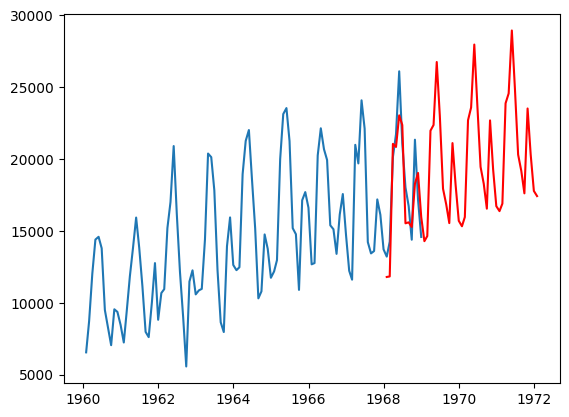

In [12]:
# データのプロット
plt.plot(data)
plt.plot(pred, color="r")
plt.show()